In [21]:
import pandas as pd
import numpy as np                                  # Import Required Libraries
import matplotlib.pyplot as plt

In [ ]:
 # Load Sample Data

In [2]:
comments_data = {
    'comment_id': [1, 2, 3],
    'post_id': [101, 101, 102],
    'user_id': [201, 202, 203],
    'text': [
        "Very informative post. Helped a lot!",
        "Didn't understand the concept clearly.",
        "This tutorial is decent, but could be better."
    ],
    'timestamp': ['2025-07-29 10:21:33', '2025-07-29 11:05:22', '2025-07-29 12:45:00']
}
comments = pd.DataFrame(comments_data)

In [3]:
comments

,comment_id,post_id,user_id,text,timestamp
0,1,101,201,Very informative post. Helped a lot!,2025-07-29 10:21:33
1,2,101,202,Didn't understand the concept clearly.,2025-07-29 11:05:22
2,3,102,203,"This tutorial is decent, but could be better.",2025-07-29 12:45:00


In [4]:
engagement_data = {
    'post_id': [101, 102],
    'likes': [120, 45],
    'dislikes': [5, 20],
    'avg_read_time_seconds': [300, 180],
    'category': ['tutorial', 'opinion']
}
engagement = pd.DataFrame(engagement_data)

In [5]:
engagement

,post_id,likes,dislikes,avg_read_time_seconds,category
0,101,120,5,300,tutorial
1,102,45,20,180,opinion


In [7]:
df = comments.merge(engagement, on='post_id')  #Merge the Data on post_id
df


,comment_id,post_id,user_id,text,timestamp,likes,dislikes,avg_read_time_seconds,category
0,1,101,201,Very informative post. Helped a lot!,2025-07-29 10:21:33,120,5,300,tutorial
1,2,101,202,Didn't understand the concept clearly.,2025-07-29 11:05:22,120,5,300,tutorial
2,3,102,203,"This tutorial is decent, but could be better.",2025-07-29 12:45:00,45,20,180,opinion


In [20]:
from transformers import pipeline

In [8]:
 # Sentiment Analysis using Transformers
sentiment_pipeline = pipeline("sentiment-analysis",                         model="distilbert-base-uncased-finetuned-sst-2-english")
df['sentiment_raw'] = df['text'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [9]:
def map_sentiment(label):  # Map sentiment to numeric scores
    if label == 'POSITIVE':
        return 1
    elif label == 'NEGATIVE':
        return -1
    else:
        return 0

In [10]:
df['sentiment_score'] = df['sentiment_raw'].apply(map_sentiment)

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()  # Normalize Engagement Metrics
df[['likes_norm', 'dislikes_norm', 'read_time_norm']] = scaler.fit_transform(
    df[['likes', 'dislikes', 'avg_read_time_seconds']]
)


In [13]:
category_weights = {
    'tutorial': 1.2,
    'opinion': 1.0,
}                    # Assign Category Weights

In [14]:
df['category_weight'] = df['category'].map(category_weights)

In [15]:
# Calculate Final Relevance Score using this formula
df['relevance_score'] = (
    df['sentiment_score'] * 0.4 +
    df['likes_norm'] * 0.3 -
    df['dislikes_norm'] * 0.1 +
    df['read_time_norm'] * 0.2
) * df['category_weight']

In [16]:
relevance_per_post = df.groupby('post_id')['relevance_score'].mean().reset_index()
print(relevance_per_post)  # group by Post ID to Get Final Score per Post

   post_id  relevance_score
0      101              0.6
1      102              0.3


In [17]:
df.to_csv("final_sentiment_engagement_data.csv", index=False)
relevance_per_post.to_csv("relevance_scores.csv", index=False)

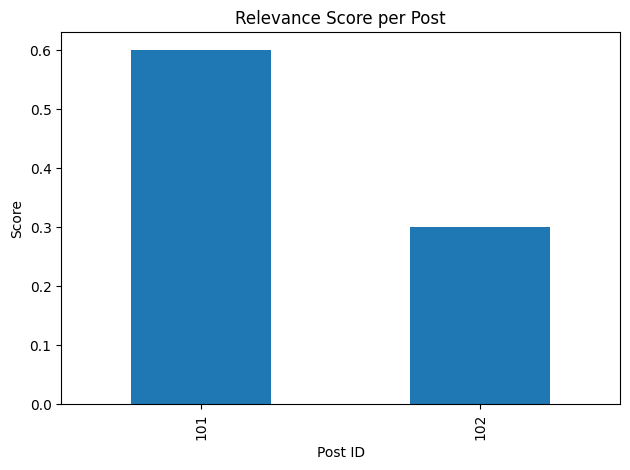

In [18]:
relevance_per_post.plot(kind='bar', x='post_id', y='relevance_score', legend=False)
plt.title("Relevance Score per Post")
plt.ylabel("Score")
plt.xlabel("Post ID")
plt.tight_layout()
plt.show()